## Loan Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,classification_report
from mpl_toolkits.mplot3d import Axes3D # 3d scatter plot
import time
%matplotlib inline

In [2]:
# parameters
n_centroids = 2
n_init = 40
n_seed = 199

In [3]:
# load training set
train = pd.read_csv('./clean_data/loan_train.txt',index_col=False)
train_labels = train['loan_status'].values
train = train.drop('loan_status',axis=1).values

# load testing set
test = pd.read_csv('./clean_data/loan_test.txt',index_col=False)
test_labels = test['loan_status'].values
test = test.drop('loan_status',axis=1).values

In [4]:
# normalize everything such that categoricals are not affected
a = train
train = (a - a.mean()) / np.std(a)
b = test
test = (b - b.mean()) / np.std(b)

### Apply K Means

In [5]:
kmeans = KMeans(n_clusters=n_centroids, n_init=1, random_state=n_seed, n_jobs=4)
kmeans.fit(train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=1, n_jobs=4, precompute_distances='auto',
    random_state=199, tol=0.0001, verbose=0)

In [6]:
print(confusion_matrix(train_labels,kmeans.labels_))
print(classification_report(train_labels,kmeans.labels_))

[[15699  1835]
 [40872  5803]]
             precision    recall  f1-score   support

          0       0.28      0.90      0.42     17534
          1       0.76      0.12      0.21     46675

avg / total       0.63      0.33      0.27     64209



### Predicting on test set

In [7]:
b = kmeans.predict(test)

In [8]:
print(confusion_matrix(test_labels, b))
print(classification_report(test_labels, b))

[[ 6881   964]
 [17650  3042]]
             precision    recall  f1-score   support

          0       0.28      0.88      0.43      7845
          1       0.76      0.15      0.25     20692

avg / total       0.63      0.35      0.30     28537



## Choosing number of clusters via Silhoutte + Model Complexity

In [9]:
from sklearn.metrics import silhouette_samples, silhouette_score
nclusters = 50
nfeatures = 65
data_frac = 5000

In [10]:
X = train #.values # converting df to np.array
X = X[0:data_frac]
y = train_labels

In [11]:
sil = []
time_clust = []
for iclusters in range(2,nclusters):
    start = time.time()
    clusterer = KMeans(n_clusters=iclusters,random_state=n_seed,n_init=1)
    cluster_labels = clusterer.fit_predict(X)
    end = time.time()
    sil.append(silhouette_score(X, cluster_labels))
    time_clust.append(end - start) 
    

In [12]:
time_iter = []
time_sample = []
niter = nclusters # just for plotting them togather
for iiter in range(2,niter):
    # iterations
    start = time.time()
    clusterer = KMeans(n_clusters= 2, random_state=iiter, n_init = iiter, max_iter = 100)
    cluster_labels = clusterer.fit_predict(X)
    end = time.time()
    time_iter.append(end - start)    
    #samples
    start = time.time()
    isample = int(data_frac * iiter/100)
    clusterer = KMeans(n_clusters= 2, random_state=n_seed, n_init = 1, max_iter = 100)
    cluster_labels = clusterer.fit_predict(X[0:isample])
    end = time.time()
    time_sample.append(end - start)      
       

In [13]:
y = np.asarray(sil)
x = range(2,nclusters)
sil_max = x[y.argmax()]

/home/talant/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


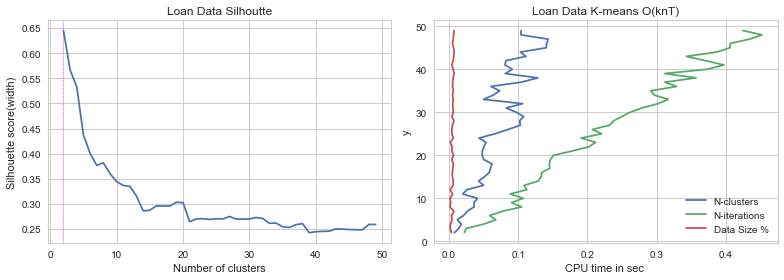

In [14]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(11,4))
p1 = plt.subplot(121, title = 'Loan Data Silhoutte')
plt.plot(x, y)
plt.ylabel('Silhouette score(width)')
plt.xlabel('Number of clusters')
plt.axvline(x=sil_max,color='magenta', linestyle='--', linewidth=0.5)

p2 = plt.subplot(122, title = 'Loan Data K-means O(knT)')
plt.plot(time_clust,x)
plt.plot(time_iter,x)
plt.plot(time_sample,x)
plt.legend(["N-clusters","N-iterations","Data Size %"],loc=4)
plt.xlabel('CPU time in sec ')
plt.ylabel('y')

fig.set_tight_layout(True)
plt.show()
fig.savefig('plots/LC_ModComp_Kmeans.pdf')

**The average complexity is given by O(k n T), were n is the number of samples and T is the number of iteration.**

### Apply EM

In [15]:
from sklearn.mixture import GaussianMixture

In [16]:
gm = GaussianMixture(n_components=n_centroids, random_state=n_seed, n_init=1, max_iter=100)
gm.fit(train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=199, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [17]:
gm_labels = gm.predict(train)

In [18]:
print(confusion_matrix(train_labels, gm_labels))
print(classification_report(train_labels, gm_labels))

[[15126  2408]
 [40839  5836]]
             precision    recall  f1-score   support

          0       0.27      0.86      0.41     17534
          1       0.71      0.13      0.21     46675

avg / total       0.59      0.33      0.27     64209



In [19]:
test_gm = gm.predict(test)
print(confusion_matrix(test_labels, test_gm))
print(classification_report(test_labels, test_gm))

[[    0  7845]
 [    0 20692]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      7845
          1       0.73      1.00      0.84     20692

avg / total       0.53      0.73      0.61     28537



/home/talant/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## EM model Complexity + Choosing n-components

In [20]:
BIC = []
AIC = []
time_components = []
ncomponents = 50
for icomponents in range(1,ncomponents):
    start = time.time()
    clusterer = GaussianMixture(n_components=icomponents, n_init = 1, covariance_type='full',random_state=n_seed).fit(X) 
    end = time.time()
    BIC.append(clusterer.bic(X))
    AIC.append(clusterer.aic(X))
    time_components.append(end - start) 

In [21]:
time_iter = []
time_sample = []
niter = ncomponents  
for iiter in range(1,niter):
    # iterations
    start = time.time()
    clusterer = GaussianMixture(n_components = 2, n_init=iiter, covariance_type='full',random_state=iiter).fit(X) 
    end = time.time()
    time_iter.append(end - start)    
    #samples
    start = time.time()
    isample = int(data_frac * iiter/100)
    clusterer = GaussianMixture(n_components = 2, n_init = 1, covariance_type='full', random_state=n_seed).fit(X[0:isample]) 
    end = time.time()
    time_sample.append(end - start)      

/home/talant/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


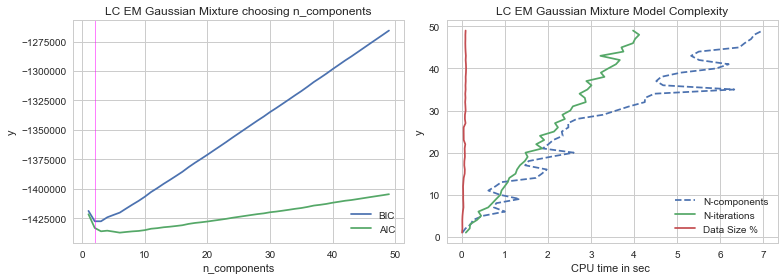

In [22]:
x = np.arange(1, ncomponents)
sns.set_style("whitegrid")
fig = plt.figure(figsize=(11,4))

p1 = plt.subplot(121, title = 'LC EM Gaussian Mixture choosing n_components')
plt.plot(x, BIC, label='BIC')
plt.plot(x, AIC, label='AIC')
plt.axvline(x=2,color='magenta', linewidth=0.5)
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('y')

p2 = plt.subplot(122, title = 'LC EM Gaussian Mixture Model Complexity')
plt.plot(time_components,x, linestyle='--')
plt.plot(time_iter,x)
plt.plot(time_sample,x)
plt.legend(["N-components","N-iterations","Data Size %"],loc=4)
plt.xlabel('CPU time in sec ')
plt.ylabel('y')

fig.set_tight_layout(True)
plt.show()
fig.savefig('plots/LC_ModComp_EM.pdf')

# Note!
**Since training was not provided any information about target feature, it makes sence to see very close accuracy
on both training and testing sets.**

### Apply PCA to Normalized Data 

In [23]:
from sklearn.decomposition import PCA, FastICA

In [24]:
train = pd.DataFrame(train)
n_features = len(train.columns)

## Try it on whole data

In [25]:
# when n_comp is given as fraction and svd solver is full, then algorithm chooses # pc components
# such that model explains "n_components= of varience
pca_all = PCA(n_components=0.99,  svd_solver = 'full')
pca_all.fit(train)
pca_n = pca_all.transform(train)

/home/talant/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


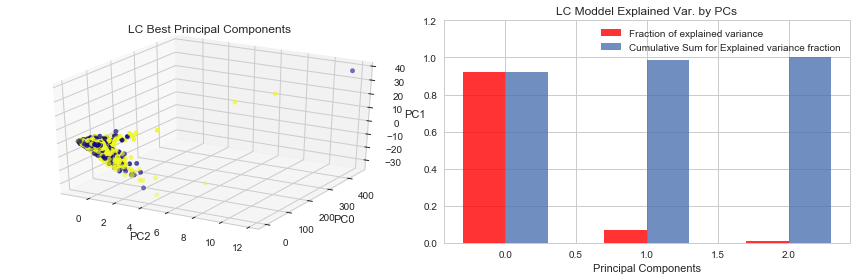

In [26]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pca_n[:,2], pca_n[:,0],pca_n[:,1],c=train_labels,cmap='plasma')
ax1.set_xlabel('PC2')
ax1.set_ylabel('PC0')
ax1.set_zlabel('PC1')
plt.title('LC Best Principal Components')

ax2 = fig.add_subplot(122)
aig_vals = pca_all.explained_variance_ratio_
y_pos = np.arange(len(aig_vals))
cumsum = np.cumsum(aig_vals)  
plt.bar(y_pos, aig_vals, align='edge', alpha=0.8, color='red', width=-0.3)
plt.bar(y_pos, cumsum, align='edge', alpha=0.8, width=0.3)
plt.legend(["Fraction of explained variance","Cumulative Sum for Explained variance fraction"],loc='best')
plt.ylabel('')
plt.ylim(0, 1.2 )
plt.xlabel('Principal Components') 
plt.title('LC Moddel Explained Var. by PCs')
fig.set_tight_layout(True)
fig.savefig('plots/LC_pca.pdf')

### Apply k-means to PCA output

In [27]:
kmeans = KMeans(n_clusters=n_centroids,n_init=1, random_state=n_seed)
kmeans.fit(pca_n)
print(confusion_matrix(train_labels,kmeans.labels_))
print(classification_report(train_labels,kmeans.labels_))

[[15688  1846]
 [40834  5841]]
             precision    recall  f1-score   support

          0       0.28      0.89      0.42     17534
          1       0.76      0.13      0.21     46675

avg / total       0.63      0.34      0.27     64209



### Apply EM to PCA output

In [28]:
gm = GaussianMixture(n_components=n_centroids, random_state=n_seed, n_init=1, max_iter=100)
gm.fit(pca_n)
gm_labels = gm.predict(pca_n)
print(confusion_matrix(train_labels, gm_labels))
print(classification_report(train_labels, gm_labels))

[[16027  1507]
 [42578  4097]]
             precision    recall  f1-score   support

          0       0.27      0.91      0.42     17534
          1       0.73      0.09      0.16     46675

avg / total       0.61      0.31      0.23     64209



##  ICA

In [29]:
ica =FastICA(algorithm='parallel', tol=0.001, whiten=True, fun='logcosh', max_iter=50, random_state=n_seed)
ica_all = ica.fit_transform(train)

### Applying k-means to ICA output

In [30]:
kmeans = KMeans(n_clusters=n_centroids, random_state = n_seed)
kmeans.fit(ica_all)
print(confusion_matrix(train_labels,kmeans.labels_))
print(classification_report(train_labels,kmeans.labels_))

[[ 1484 16050]
 [ 9110 37565]]
             precision    recall  f1-score   support

          0       0.14      0.08      0.11     17534
          1       0.70      0.80      0.75     46675

avg / total       0.55      0.61      0.57     64209



### Applying EM to ICA output

In [31]:
gm = GaussianMixture(n_components=n_centroids, random_state=n_seed, max_iter=100)
gm.fit(ica_all)
gm_labels = gm.predict(ica_all)
print(confusion_matrix(train_labels, gm_labels))
print(classification_report(train_labels, gm_labels))

[[ 4884 12650]
 [16794 29881]]
             precision    recall  f1-score   support

          0       0.23      0.28      0.25     17534
          1       0.70      0.64      0.67     46675

avg / total       0.57      0.54      0.56     64209



In [32]:
from scipy.stats import kurtosis
y = kurtosis(ica_all, fisher=True)
x = np.arange(len(y)) 

In [33]:
kurt_max = x[y.argmax()]
kurtosis_thresh = y.max()/2

### Visualize ICA components with highest Kurtosis

In [34]:
tmp = [y > kurtosis_thresh]
indx = np.where(tmp)[1]

In [35]:
ica_all = pd.DataFrame(ica_all)
ica_keep = ica_all[indx]

In [36]:
indx

array([ 4, 14, 19])

/home/talant/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


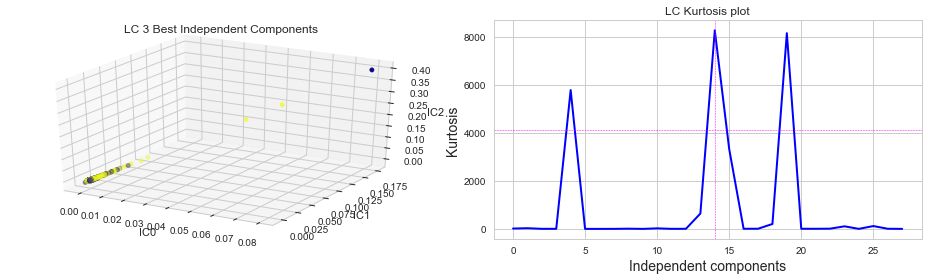

In [37]:
fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(ica_keep[indx[0]], ica_keep[indx[1]],ica_keep[indx[2]],c=train_labels,cmap='plasma')
ax1.set_xlabel('IC0')
ax1.set_ylabel('IC1')
ax1.set_zlabel('IC2')
plt.title('LC 3 Best Independent Components')

ax2 = fig.add_subplot(122)
plt.xlabel('Independent components', fontsize = 14)
plt.ylabel('Kurtosis', fontsize = 14)
plt.plot(x ,y, '-',lw=2., color='blue')
plt.axvline(x=kurt_max,color='magenta', linestyle='--', linewidth=0.5)
plt.axhline(y=kurtosis_thresh,color='magenta', linestyle='--', linewidth=0.5)
plt.title('LC Kurtosis plot')
fig.set_tight_layout(True)
fig.savefig('plots/LC_ica.pdf')

### Apply k-means to reduced dim by ICA

In [38]:
kmeans = KMeans(n_clusters=n_centroids, random_state = n_seed)
kmeans.fit(ica_keep)
print(confusion_matrix(train_labels,kmeans.labels_))
print(classification_report(train_labels,kmeans.labels_))

[[17533     1]
 [46673     2]]
             precision    recall  f1-score   support

          0       0.27      1.00      0.43     17534
          1       0.67      0.00      0.00     46675

avg / total       0.56      0.27      0.12     64209



### Apply EM to reduced dim by ICA

In [39]:
gm = GaussianMixture(n_components=n_centroids, random_state=n_seed, max_iter=100)
gm.fit(ica_keep)
gm_labels = gm.predict(ica_keep)
print(confusion_matrix(train_labels, gm_labels))
print(classification_report(train_labels, gm_labels))

[[17334   200]
 [46107   568]]
             precision    recall  f1-score   support

          0       0.27      0.99      0.43     17534
          1       0.74      0.01      0.02     46675

avg / total       0.61      0.28      0.13     64209



In [40]:
ica_n = ica_keep

## Random Projections

In [41]:
from sklearn import random_projection
import scipy.sparse as sps
from scipy.linalg import pinv
from collections import defaultdict

In [42]:
def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)

In [43]:
tmp = defaultdict(dict)
dims = train.shape[1]
for iseed in range(1,11):
    for dim in range(2,dims,2):
        rp = random_projection.GaussianRandomProjection(random_state=iseed, n_components=dim)
        rp.fit(train)  
        tmp[dim][iseed] = reconstructionError(rp, train)
tmp =pd.DataFrame(tmp).T

/home/talant/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


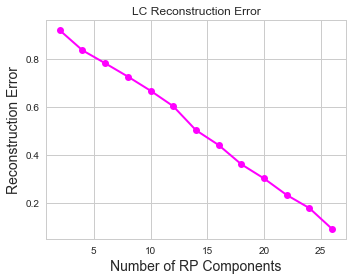

In [44]:
fig = plt.figure(figsize=(5,4))
y = tmp.mean(axis=1)
x = np.arange(2,dims,2)
ax2 = fig.add_subplot(111)
plt.xlabel('Number of RP Components', fontsize = 14)
plt.ylabel('Reconstruction Error', fontsize = 14)
plt.plot(x ,y, '-o',lw=2., color='magenta')
plt.title('LC Reconstruction Error')
fig.set_tight_layout(True)
fig.savefig('plots/LC_rpa.pdf')

In [45]:
rp_n = random_projection.GaussianRandomProjection(n_components=n_features,
                                                  eps=0.9,
                                                  random_state=n_seed).fit_transform(train)

## Factor Analysis


In [46]:
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import cross_val_score

In [ ]:
fa = FactorAnalysis(random_state=n_seed)

In [ ]:
fa_scores = []
X=train[0:5000] # try it on smaller data subset
for n in np.arange(1,30):
    fa.n_components = n
    fa_scores.append(np.mean(cross_val_score(fa, X)))


In [ ]:
sns.set_style("whitegrid")
x, y = np.arange(0,len(fa_scores)), np.array(fa_scores)
score_max = x[y.argmax()]

fig = plt.figure(figsize=(5,4))
plt.plot(x, y)
plt.xlabel('Number of FA Components', fontsize = 14)
plt.ylabel('cv score', fontsize = 14)
plt.title('LC Factor analysis CV score')
plt.axvline(x=score_max,color='magenta', linestyle='--', linewidth=0.5)
fig.set_tight_layout(True)
fig.savefig('plots/LC_fa.pdf')

In [ ]:
fa_n = FactorAnalysis(n_components= score_max, random_state=n_seed).fit_transform(X)